# STAT778: Homework 5
*Sean Steinle*

## Table of Contents
1. [Inverse Transform Sampling and Metropolis-Hastings](#Inverse-Transform-Sampling-and-Metropolis-Hastings)
    - [Inverse Transform Sampling for G](#Inverse-Transform-Sampling-for-G)
    - [A Valid Envelope](#A-Valid-Envelope)
    - [Rejection Sampling for F](#Rejection-Sampling-for-F)
2. [Gibbs Sampling](#Gibbs-Sampling)
3. [Epilogue: Metropolis-Hastings Revisited](#Epilogue:-Metropolis-Hastings-Revisited)

## Inverse Transform Sampling and Metropolis-Hastings

### Inverse Transform Sampling for G

Question 1a asks us to create a sampler for g.
1. We can treat g(x,y|z) as two independent variables g(x|z) and g(y|z).
2. Both g(x|z) and g(y|z) have the same functional form as each other. The only different is that x is distributed from (-inf,inf) while y is distributed from \[0,inf).
3. Both g(x|z) and g(y|z) have the same functional form as the Laplace distribution, where z is the location parameter and diversity is set sqrt(2). Note that g(x|z) amnd g(y|z) are scaled by a factor of 2*sqrt(2).
4. Because we know the Laplace distribution has a closed-form inverse, we can use inverse transform sampling to generate random numbers of the same functional form as g(x|z) and g(y|z).

In [1]:
#imports
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import uniform, normal, laplace
from numpy import sign,linspace
from math import exp, log
from scipy.stats import truncnorm

In [2]:
def slaplace(z: float = 0, beta: float = 1): 
    """Generates samples from the Laplace distribution where z is the location parameter and beta is the diversity parameter."""
    u = uniform() #draw u, a float from [0,1]
    sample = z - beta * sign(u - 0.5) * log(1 - 2 * abs(u - 0.5)) #transform u using inverse cdf of the laplace distribution
    return sample #rescale sample

def g(x_loc: float, y_loc: float):
    """Uses our Laplace samplers to sample our two variables."""
    x_draw = slaplace(x_loc)
    y_draw = -1
    while y_draw < 0:
        y_draw = slaplace(y_loc)
    return x_draw,y_draw

def g_density(x: float, y: float, z: float = 0):
    """Calculates density of g for theta = (x,y). Assume z = 0."""
    return exp(-abs(x-z)/(2**0.5)) - exp(-abs(y-z)/(2**0.5))
    
def f_density(x: float, y: float, z: float = 0): #PROBLEM: this is density!
    """Calculates density of f for theta = (x,y). Assume z = 0."""
    if x>=y: return 0
    return exp(-abs((x-z)*(y-z)) - max(abs(x-z),abs(y-z)))

In [3]:
x,y = 1,1.1
exp(0),g_density(x,y),f_density(x,y)

(1.0, 0.03366109771604264, 0.11080315836233387)

(array([6.0000e+00, 6.2000e+01, 7.8900e+02, 7.6550e+03, 6.1957e+04,
        2.6578e+04, 2.6560e+03, 2.5800e+02, 3.6000e+01, 3.0000e+00]),
 array([-11.02354291,  -8.71471658,  -6.40589026,  -4.09706393,
         -1.78823761,   0.52058871,   2.82941504,   5.13824136,
          7.44706769,   9.75589401,  12.06472034]),
 <BarContainer object of 10 artists>)

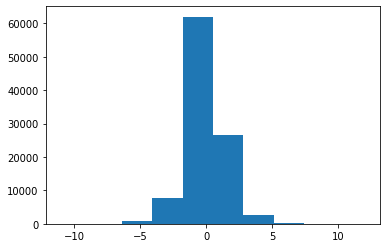

In [4]:
scaled_laplace_samples = [slaplace() for _ in range(100000)]
plt.hist(scaled_laplace_samples, bins = 10)

(array([7.0000e+00, 6.0000e+01, 4.8400e+02, 4.2710e+03, 3.9616e+04,
        4.9570e+04, 5.3960e+03, 5.2300e+02, 6.4000e+01, 9.0000e+00]),
 array([-31.74457356, -25.46123176, -19.17788996, -12.89454816,
         -6.61120635,  -0.32786455,   5.95547725,  12.23881905,
         18.52216085,  24.80550265,  31.08884446]),
 <BarContainer object of 10 artists>)

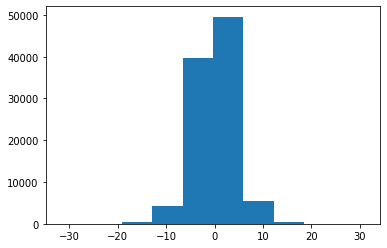

In [5]:
laplace_samples = [laplace(0, 2*(2**0.5)) for _ in range(100000)]
plt.hist(laplace_samples, bins = 10)

As a quick sanity check, we can see that our Laplace sampling function generates the same shape as Numpy's Laplace sampler.

### A Valid Envelope

Text(0.5, 1.0, 'Domains of F (Above Blue) and G (Above Red)')

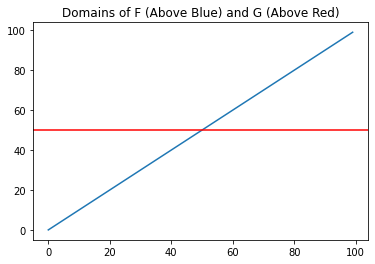

In [6]:
plt.plot(range(100))
plt.axhline(y = 50, color = 'red')
plt.title("Domains of F (Above Blue) and G (Above Red)")

To prove that g (or some scaling of g) is a valid envelope for f, we must prove two things: that g's domain spans the domain of f, and that g majorizes f.
- g's domain spans the domain of f because g's domain is a rotation of f's domain (as shown in the plot above). g's domain encompasses all real numbers above Y=0, whereas f's domain encompasses all real numbers where X>Y. The bivariate density of f when x = (x-y)/sqrt(2), y = (x+y)/sqrt(2) rotates f's domain such that g spans f's domain.
- exp(abs(z))\*g majorizes f because for all x, y, and z, exp(abs(z))\*g is greater than f.

### Rejection Sampling for F

In [62]:
z = 0
M = exp(z)

def mh_step(theta: tuple):
    """Implements one step of the Metropolis-Hastings algorithm."""
    x_curr,y_curr = theta
    x_prop,y_prop = g(x_curr,y_curr) #sample s from g(s)
    
    print(f"f: {f_density(x_prop,y_prop)}\tg: {g_density(x_prop,y_prop)}")
    #g is negative?
    
    accept_prob = min(f_density(x_prop,y_prop)/g_density(x_prop,y_prop),1) #accept with probability f(s)/g(s)+M
    return {'accepted': accept_prob >= uniform(), 'value': (x_prop,y_prop), 'accept_prob': accept_prob}

def mh(n_samples: int, n_burn: int, start_params: tuple=(1,1.1), n_lag: int=1):
    """Implements the Metropolis-Hastings algorithm."""
    results = []
    lag_count = 0
    curr_params = start_params
    for _ in range(n_burn): #burn-in period, results aren't saved
        result = mh_step(curr_params)
        if result['accepted']:
            curr_params = result['value']
    for _ in range(n_samples):
        for _ in range(n_lag):
            result = mh_step(curr_params)
            if result['accepted']:
                curr_params = result['value']
        results.append(result)
    return results

In [80]:
mh_step((0,3))

f: 0	g: -0.11033308019375543


{'accepted': False,
 'value': (2.7408257013331263, 1.9363063291865543),
 'accept_prob': -0.0}

In [26]:
results = mh(10000, 1000, (0,1))
results[:5]

[{'accepted': True,
  'value': (-1.0289883999242795, 0.7692091558298726),
  'accept_prob': 1},
 {'accepted': False,
  'value': (-1.1729953075721107, 1.365948995368252),
  'accept_prob': 0.31736426656789285},
 {'accepted': False,
  'value': (-3.6966226466433767, 1.8618795021359913),
  'accept_prob': 0.0001570741012985322},
 {'accepted': False,
  'value': (-1.3870307587865796, 1.6780269217728485),
  'accept_prob': 0.11247703877406068},
 {'accepted': False,
  'value': (-1.5221034232608481, 3.326849075452456),
  'accept_prob': 0.0014015706988772816}]

In [27]:
df = pd.DataFrame(results)
df[['X', 'Y']] = pd.DataFrame(df['value'].tolist(), index=df.index)
df

,accepted,value,accept_prob,X,Y
0,True,"(-1.0289883999242795, 0.7692091558298726)",1.000000,-1.028988,0.769209
1,False,"(-1.1729953075721107, 1.365948995368252)",0.317364,-1.172995,1.365949
2,False,"(-3.6966226466433767, 1.8618795021359913)",0.000157,-3.696623,1.861880
3,False,"(-1.3870307587865796, 1.6780269217728485)",0.112477,-1.387031,1.678027
4,False,"(-1.5221034232608481, 3.326849075452456)",0.001402,-1.522103,3.326849
...,...,...,...,...,...
9995,False,"(-0.280337924426586, 4.566056466167218)",0.145812,-0.280338,4.566056
9996,True,"(-0.3603368885470417, 2.8774435743242837)",1.000000,-0.360337,2.877444
9997,True,"(0.158431138466694, 1.4404067535167637)",1.000000,0.158431,1.440407
9998,False,"(5.965002381549593, 1.601682635504772)",0.000000,5.965002,1.601683


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-9.82622768, -9.63618534, -9.44614301, -9.25610068, -9.06605834,
        -8.87601601, -8.68597368, -8.49593134, -8.30588901, -8.11584668,
        -7.92580435, -7.73576201, -7.54571968, -7.35567735, -7.16563501,
        -6.97559268, -6.78555035, -6.59550801, -6.40546568, -6.21542335,
        -6.02538101, -5.83533868, -5.64529635, -5.45525401, -5.26521168,
        -5.07516935, -4.88512701, -4.69508468, -4.50504235, -4.31500002,
        -4.12495768, -3.93491535, -3.74487302, -3.55483068, -3.36478835,
        -3.17474602, -2.98470368, -2.79466135, -2.60461902, -2.41457668,
        -2.22453435, -2.03449202, -1.84444968, -1.65440735, -1.46436502,
        -1.27432268, -1.08428035, -0.89423802, -0.70419569, -0.51415335,
        -0.32411102, 

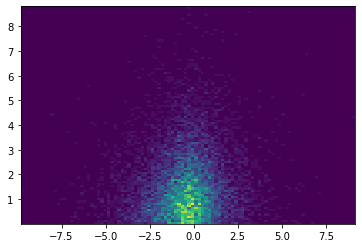

In [28]:
plt.hist2d(df['X'],df['Y'], bins = 100)

(array([4307.,  883.,  629.,  499.,  435.,  345.,  344.,  304.,  257.,
        1997.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

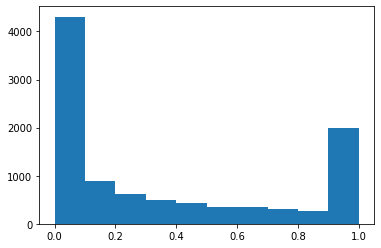

In [29]:
plt.hist(df['accept_prob'])

Our Metropolis-Hastings algorithm looks good! We see that X looks like a typical Laplace distribution and Y is similar but cut off. Out of curiosity, will we still see convergence even if we try from many directions?

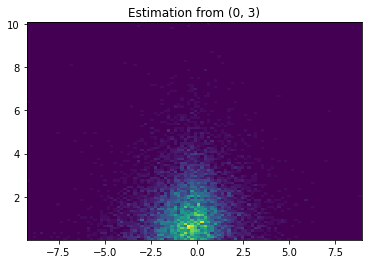

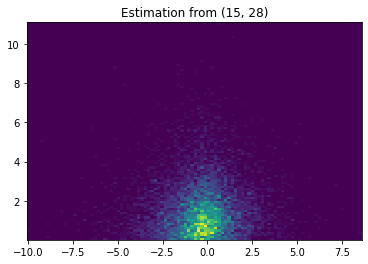

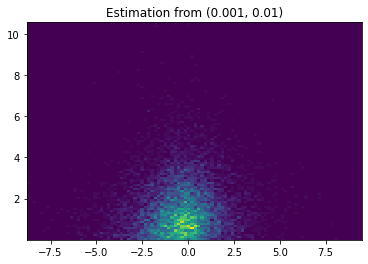

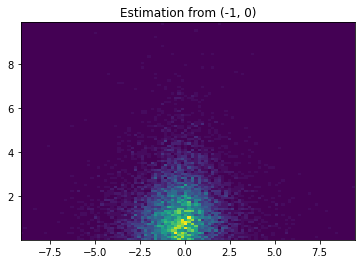

In [30]:
for start in [(0,3),(15,28),(0.001,0.01),(-1,0)]:
    results = mh(10000, 1000, start)
    df = pd.DataFrame(results)
    df[['X', 'Y']] = pd.DataFrame(df['value'].tolist(), index=df.index)
    plt.hist2d(df['X'],df['Y'], bins = 100)
    plt.title(f"Estimation from {start}")
    plt.show()

Looks like the answer is yes!

In [31]:
target_df = df[df['accepted']]
target_df

,accepted,value,accept_prob,X,Y
1,True,"(-0.05000901450277734, 0.8171164668339621)",0.965967,-0.050009,0.817116
8,True,"(0.04658606388081789, 2.619409002439421)",0.152063,0.046586,2.619409
9,True,"(-0.0072310065636094, 2.595166007438716)",1.000000,-0.007231,2.595166
13,True,"(0.7462037733981205, 1.5768472999150895)",0.869736,0.746204,1.576847
16,True,"(-0.9034756776931606, 1.4939155463675917)",0.913808,-0.903476,1.493916
...,...,...,...,...,...
9987,True,"(0.8206179825073234, 1.936738700550459)",0.987239,0.820618,1.936739
9988,True,"(0.6792890562208185, 1.391300227042271)",1.000000,0.679289,1.391300
9992,True,"(0.928235786495695, 1.2578648413528275)",0.914786,0.928236,1.257865
9993,True,"(0.2312103545183628, 2.3691202421626754)",0.611754,0.231210,2.369120


Text(0, 0.5, 'Y')

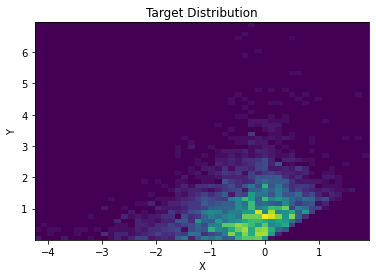

In [32]:
plt.hist2d(target_df['X'],target_df['Y'], bins = 50)
plt.title("Target Distribution")
plt.xlabel("X")
plt.ylabel("Y")

Look! We can see the x\<y restriction imposed by our target function F represented graphically here.

In [33]:
misses_df = df[~df['accepted']]
misses_df

,accepted,value,accept_prob,X,Y
0,False,"(1.3137135352581326, 0.7469129164592048)",0.000000,1.313714,0.746913
2,False,"(-1.2909934684053874, 1.6574334349953448)",0.052909,-1.290993,1.657433
3,False,"(0.746756618292945, 2.331809991478557)",0.040150,0.746757,2.331810
4,False,"(-5.869891577658005, 0.03622283219636113)",0.005383,-5.869892,0.036223
5,False,"(-0.7890464546482026, 2.0272804084360327)",0.062730,-0.789046,2.027280
...,...,...,...,...,...
9994,False,"(-2.1228421837348765, 2.4346786507369256)",0.009221,-2.122842,2.434679
9995,False,"(-0.3579557966543049, 2.988083997888568)",0.319563,-0.357956,2.988084
9997,False,"(-0.1435012442831276, 4.3736411458384605)",0.207201,-0.143501,4.373641
9998,False,"(0.932881119425125, 6.340651555198841)",0.000146,0.932881,6.340652


Text(0, 0.5, 'Y')

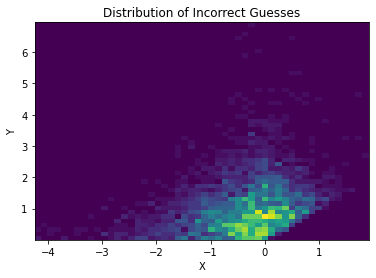

In [34]:
plt.hist2d(target_df['X'],target_df['Y'], bins = 50)
plt.title("Distribution of Incorrect Guesses")
plt.xlabel("X")
plt.ylabel("Y")

Our densest area again draws our attention to our learning of the x\<y rule!

## Gibbs Sampling

In [18]:
def gibbs(n_samples: int, n_burns: int, start_params: tuple=(-1,1,0)):
    d = {'x': [], 'y': [], 'z': []}

    x,y,z = start_params
    #burnin
    for i in range(n_burns):
        z = truncnorm.rvs(x,y) if x < y else truncnorm.rvs(y,x)
        x,y = g(z,z)

    #gather samples!
    for i in range(n_samples):
        z = truncnorm.rvs(x,y) if x < y else truncnorm.rvs(y,x)
        x,y = g(z,z)
        d['x'].append(x)
        d['y'].append(y)
        d['z'].append(z)
        #print(f"iteration #{i}: ({x},{y},{z})")
    
    return pd.DataFrame(d)

In [19]:
gibbs_df = gibbs(100000, 10000)

In [20]:
gibbs_df

,x,y,z
0,-0.626833,0.015258,-0.621638
1,-0.224597,0.606540,-0.581690
2,1.540676,1.960491,-0.055379
3,2.654150,1.834145,1.883994
4,3.161615,2.497614,2.520720
...,...,...,...
99995,2.738179,3.366146,2.120497
99996,2.754578,3.222428,3.023349
99997,3.381244,3.093416,2.813445
99998,2.184240,4.396379,3.242199


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-12.24586223, -11.7001359 , -11.15440957, -10.60868324,
        -10.06295691,  -9.51723058,  -8.97150425,  -8.42577792,
         -7.88005159,  -7.33432527,  -6.78859894,  -6.24287261,
         -5.69714628,  -5.15141995,  -4.60569362,  -4.05996729,
         -3.51424096,  -2.96851463,  -2.42278831,  -1.87706198,
         -1.33133565,  -0.78560932,  -0.23988299,   0.30584334,
          0.85156967,   1.397296  ,   1.94302233,   2.48874865,
          3.03447498,   3.58020131,   4.12592764,   4.67165397,
          5.2173803 ,   5.76310663,   6.30883296,   6.85455929,
          7.40028561,   7.94601194,   8.49173827,   9.0374646 ,
          9.58319093,  10.12891726,  10.67464359,  11.22036992,
         11.76609625,  12.31182257,  12.8575489

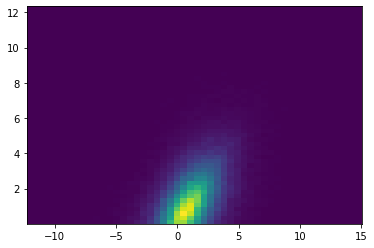

In [21]:
plt.hist2d(gibbs_df['x'],gibbs_df['y'], bins = 50)

<AxesSubplot:>

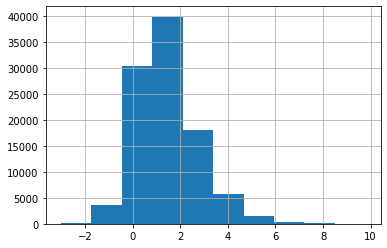

In [22]:
gibbs_df['z'].hist()

These look great! However, we can already see one key distinction between Metropolis-Hastings and Gibbs sampling--Gibbs sampling does not reject samples. While our the distribution of our accepted samples in Metropolis-Hastings drew a sharp line on x = y, Gibbs sampling does not. The line does still show in Gibbs, but it isn't as precisely defined because there is no concept of rejection.

Let's now explore how varying our starting point changes our results.

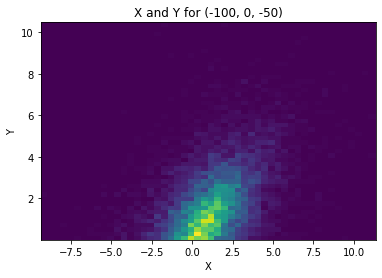

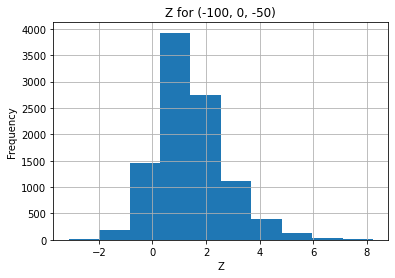

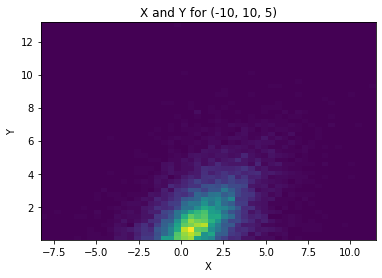

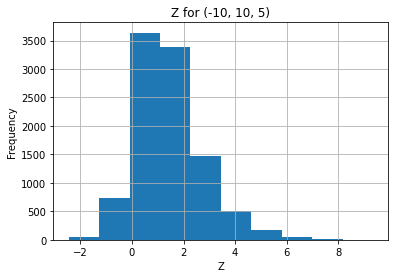

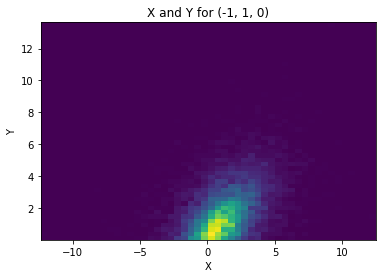

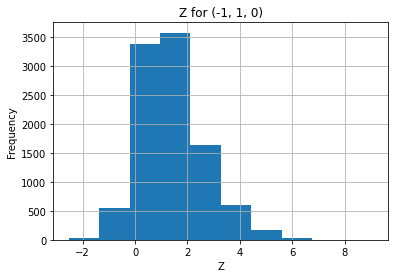

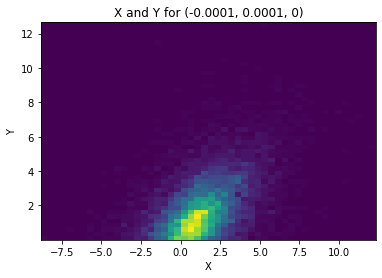

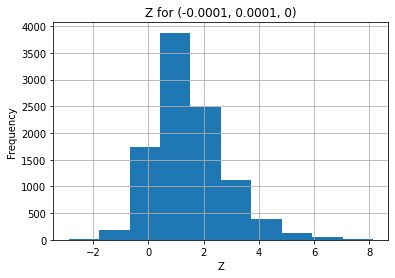

In [23]:
for start in [(-100,0,-50), (-10,10,5), (-1,1,0), (-0.0001,0.0001,0)]:
    gibbs_df = gibbs(10000, 5000, start)
    plt.hist2d(gibbs_df['x'],gibbs_df['y'], bins = 50)
    plt.title(f"X and Y for {start}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()
    gibbs_df['z'].hist()
    plt.title(f"Z for {start}")
    plt.xlabel("Z")
    plt.ylabel("Frequency")
    plt.show()

From the looks of things, in all four start cases Gibbs converges to the target distribution.

## Epilogue: Metropolis-Hastings Revisited

In [84]:
z = 0
M = exp(z)

def mh_step(theta: tuple):
    """Implements one step of the Metropolis-Hastings algorithm."""
    x_curr,y_curr = theta
    x_prop,y_prop = g(x_curr,y_curr) #sample s from g(s)
    
    #g is negative?
    
    #(f_density(x_prop,y_prop)*h_ji) /
    #(f_density(x_curr,y_curr)*h_ij)
    #what's h_ij/h_ji here? https://stats.stackexchange.com/questions/27913/acceptance-ratio-in-metropolis-hastings-algorithm
    #note: if h_ij == h_ji, then this is just Metropolis and we can just do f(prop)/f(curr). let's assume that for now.
    
    accept_prob = min(f_density(x_prop,y_prop)/f_density(x_curr,y_curr), 1) #accept with probability f(s)/g(s)+M
    
    return {'accepted': accept_prob >= uniform(), 'value': (x_prop,y_prop), 'accept_prob': accept_prob}

def mh(n_samples: int, n_burn: int, start_params: tuple=(1,1.1), n_lag: int=1):
    """Implements the Metropolis-Hastings algorithm."""
    results = []
    lag_count = 0
    curr_params = start_params
    for _ in range(n_burn): #burn-in period, results aren't saved
        result = mh_step(curr_params)
        if result['accepted']:
            curr_params = result['value']
    for _ in range(n_samples):
        for _ in range(n_lag):
            result = mh_step(curr_params)
            if result['accepted']:
                curr_params = result['value']
        results.append(result)
    return results

In [136]:
mh_step((0,3))
#what was I programming originally? was it right?

f: 6.621829658754603e-09	g: -0.011938523059587466


{'accepted': False,
 'value': (-3.9843148532417345, 3.7267585056346153),
 'accept_prob': 1.3300300410997477e-07}

- This was the general structure of my Metropolis-Hastings code. You mentioned that I did Metropolis-Hastings when I really should have done rejection sampling, but is my Metropolis-Hastings code correct?
    - I actually can see this is really only the Metropolis case now, how would I calculate h_ji and h_ij which are necessary?
- Now to make it adaptive? I keep track of previous guesses right?
- What do I do for a simulated study? The study showed two examples, one was low dimensional, just a bimodal situation. THe other was more high dimensional. What do I pick for f? Should I pick a few different examples, some of them showing why adaptiveness is effective and others not?

### To-Do:
1. Look at adaptive algorithm (in Arman's slides), see if I can adapt my code to it.
2. Make an example new f for simulation tests.